
### T1 Data Analysis  

        Sean Keenan, PhD Physics  
        Quantum Memories Group, Heriot-Watt University, Edinburgh  
        2021  

In [15]:
import os
import spec_funcs as sf
import fit_funcs as ff
from filter_funcs import moving_av
from scipy.signal import fftconvolve
import numpy as np
import matplotlib.pyplot as mp

mp.style.use('signature.mplstyle')

path = r"C:\Users\sk88\Desktop\test_T1"

In [16]:
folder_list, file_list = sf.dir_interogate(path, extensions=('.csv', '.txt'))
path_names = sf.read_files(folder_list, file_list)
selected_files = [sf.search_paths(paths, keys=['.txt']) for paths in path_names]
info_paths = [column[0] for column in selected_files]
excel_paths = [column[1] for column in selected_files]
info_folders = [[sf.open_excel(os.path.join(path, file_path)) for file_path in info_file_paths] for info_file_paths in info_paths]
excel_folders = [[sf.open_excel(os.path.join(path, file_path)) for file_path in excel_file_paths] for excel_file_paths in excel_paths]


##### Import Data  
        
        Load data sets & extract time and voltage data


In [17]:
time_data_sets = [[excel_file[0] for excel_file in excel_folder] for excel_folder in excel_folders]
trigger_data_sets = [[excel_file[1] for excel_file in excel_folder] for excel_folder in excel_folders]
transmitted_data_sets = [[excel_file[2] for excel_file in excel_folder] for excel_folder in excel_folders]
reference_data_sets = [[excel_file[3] for excel_file in excel_folder] for excel_folder in excel_folders]
times = [x *1E6 for x in time_data_sets[0][0]]


##### Check channel assignment  

        Plot one of each channel to check assignment is correct for calculations


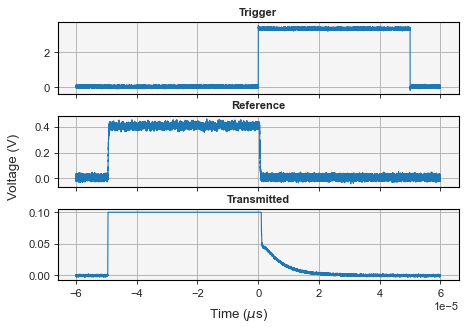

In [18]:
fig, ax = mp.subplots(nrows=3, ncols=1, sharex='all')
# shared labels
fig.tight_layout(w_pad=2, rect=[0.05, 0.05, 1, 1])
fig.supxlabel('Time ($\mu$s)')
fig.supylabel('Voltage (V)')

ax[0].set_title('Trigger')
ax[0].plot(time_data_sets[0][0], trigger_data_sets[0][0])
ax[1].set_title('Reference')
ax[1].plot(time_data_sets[0][0], reference_data_sets[0][0])
ax[2].set_title('Transmitted')
ax[2].plot(time_data_sets[0][0], transmitted_data_sets[0][0])


##### Fine Tune Trigger Point

        Check the trigger index and adjust if neccesary
        

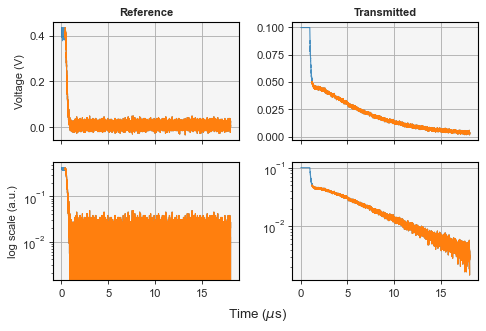

In [19]:
# find the trigger indexes
trig_indexes = [[sf.find_trigger(trigger_data, modifier=0.989) for trigger_data in trigger_list] for trigger_list in trigger_data_sets]
# plot small portion to check ramp off on transmitted data
ramp_off = 15000 + trig_indexes[0][0]
# pick an offset
ref_offset = 300
offset = 1000
# plot the transmitted data from trigger point and compare with the offset 
fig, ax = mp.subplots(ncols=2, nrows=2, sharex=True)
# shared labels
fig.tight_layout(w_pad=2, rect=[0, 0.05, 1, 1])
fig.supxlabel('Time ($\mu$s)')
# plot on separate subplots
ax[0][0].set_title('Reference')
ax[0][0].plot(times[trig_indexes[0][0]:ramp_off], reference_data_sets[0][0][trig_indexes[0][0]:ramp_off], label='raw', alpha=0.8)
ax[0][0].plot(times[trig_indexes[0][0]+ref_offset:ramp_off], reference_data_sets[0][0][trig_indexes[0][0]+ref_offset:ramp_off], label='cut')
ax[0][0].set(ylabel='Voltage (V)')

ax[0][1].set_title('Transmitted')
ax[0][1].plot(times[trig_indexes[0][0]:ramp_off], transmitted_data_sets[0][0][trig_indexes[0][0]:ramp_off], label='raw', alpha=0.8)
ax[0][1].plot(times[trig_indexes[0][0]+offset:ramp_off], transmitted_data_sets[0][0][trig_indexes[0][0]+offset:ramp_off], label='cut')

ax[1][0].plot(times[trig_indexes[0][0]:ramp_off], reference_data_sets[0][0][trig_indexes[0][0]:ramp_off], label='raw', alpha=0.8)
ax[1][0].plot(times[trig_indexes[0][0]+ref_offset:ramp_off], reference_data_sets[0][0][trig_indexes[0][0]+ref_offset:ramp_off], label='cut')
ax[1][0].set(ylabel='log scale (a.u.)')
ax[1][0].set_yscale('log')

ax[1][1].plot(times[trig_indexes[0][0]:ramp_off], transmitted_data_sets[0][0][trig_indexes[0][0]:ramp_off], label='raw', alpha=0.8)
ax[1][1].plot(times[trig_indexes[0][0]+offset:ramp_off], transmitted_data_sets[0][0][trig_indexes[0][0]+offset:ramp_off], label='cut')
ax[1][1].set_yscale('log')


##### Process Data  

        Remove negatives and create smoothed and normalised sets


In [20]:
# initial guess for the decay times (us)
guess_ref_T1 = 1E-6
guess_T1 = 10E-6
# shorten data for fitting by finding last index of useful data
ref_stop_indexes = [[round(guess_ref_T1*5 / (time[1] - time[0])) for time in time_lists] for time_lists in time_data_sets]
stop_indexes = [[round(guess_T1*4  / (time[1] - time[0])) for time in time_lists] for time_lists in time_data_sets]
# generate new list of trigger indexes plus the offset
new_trig_indexes = [[value + offset for value in trig_index] for trig_index in trig_indexes]
ref_trig_indexes = [[value + ref_offset for value in trig_index] for trig_index in trig_indexes]
# trim the data sets to only contain data from the trigger onward to the end of useful data index
time_cut_data_sets = [[time[start:start+stop] for time, start, stop in zip(time_set, start_set, stop_set)] for time_set, start_set, stop_set in zip(time_data_sets, new_trig_indexes, stop_indexes)]
ref_cut_time_data_sets = [[ref_time[start:start+stop] for ref_time, start, stop in zip(ref_time_set, start_set, stop_set)] for ref_time_set, start_set, stop_set in zip(time_data_sets, ref_trig_indexes, stop_indexes)]
trans_cut_data_sets = [[trans[start:start+stop] for trans, start, stop in zip(trans_set, start_set, stop_set)] for trans_set, start_set, stop_set in zip(transmitted_data_sets, new_trig_indexes, stop_indexes)]
ref_cut_data_sets = [[ref[start:start+stop] for ref, start, stop in zip(ref_set, start_set, stop_set)] for ref_set, start_set, stop_set in zip(reference_data_sets, ref_trig_indexes, stop_indexes)]
# find max and min values in transmitted data for list comprehension
list_of_mins = [[min(trans_list) for trans_list in transmitted_lists] for transmitted_lists in transmitted_data_sets]
list_of_maxs = [[max(trans_cut_list) for trans_cut_list in trans_cut_lists] for trans_cut_lists in trans_cut_data_sets]
ref_min_list = [[min(ref_list) for ref_list in reference_lists] for reference_lists in reference_data_sets]
ref_max_list = [[max(ref_list) for ref_list in ref_cut_lists] for ref_cut_lists in ref_cut_data_sets]
# create a boxcar window and then create a list of smoothed data
avg_window = moving_av(10)
length_avg_window = avg_window.shape[0] // 2
# create lists of smoothed, corrected, smoothed and corrected
ref_corrected = [[sf.zero_data(ref_list) for ref_list in reference_lists] for reference_lists in ref_cut_data_sets]
trans_smoothed = [[fftconvolve(avg_window, trans_cut_list)[length_avg_window-1:-length_avg_window] for trans_cut_list in trans_cut_lists] for trans_cut_lists in trans_cut_data_sets]
trans_corrected = [[sf.zero_data(trans_list) for trans_list in transmitted_lists] for transmitted_lists in trans_cut_data_sets]
trans_avg_cor = [[sf.zero_data(smoothed_list) for smoothed_list in smoothed_lists] for smoothed_lists in trans_smoothed]


##### Fit to Reference Detector Data
        Determine Fall Time

Fit Params data[0]:
I0 : 4627866.22 mV, T1 : 0.18 us, Y0 : 48764.91 mV
Fit Error data[0]:
dI0 : 65176.57 mV, dT1 : 0.001 us, dY0 : 63.06 mV 

Fit Params data[1]:
I0 : 4715095.34 mV, T1 : 0.18 us, Y0 : 38438.62 mV
Fit Error data[1]:
dI0 : 64689.24 mV, dT1 : 0.001 us, dY0 : 63.42 mV 



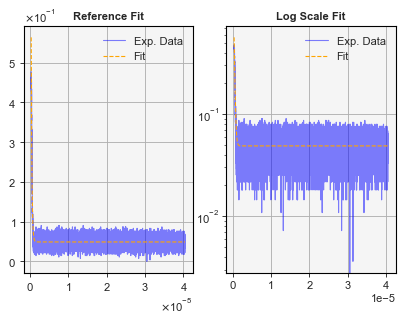

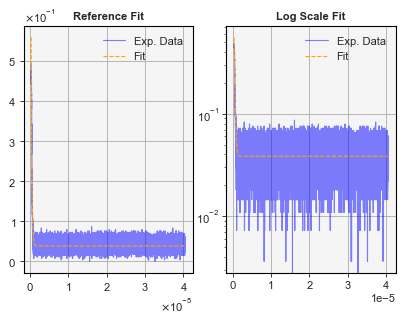

In [21]:
ref_zipped = zip(ref_cut_time_data_sets, ref_corrected, ref_max_list, ref_min_list)
reference_fit_sets = [[ff.fit_exp_decay(time, ref, params=(max_value, guess_ref_T1, min_value)) for time, ref, max_value, min_value in zip(time_set, ref_set, max_set, min_set)] for time_set, ref_set, max_set, min_set in ref_zipped]

# loop over references - fit and plot data of one set per folder
for idx, ref_fitted_set in enumerate(reference_fit_sets):

    fig, ax = mp.subplots(nrows=1, ncols=2)
    
    ax[0].set_title('Reference Fit')
    ax[0].plot(ref_cut_time_data_sets[idx][0], ref_corrected[idx][0], color='blue', alpha=0.5, label='Exp. Data')
    ax[0].plot(ref_cut_time_data_sets[idx][0], ff.exp_decay(np.array(ref_cut_time_data_sets[idx][0]), *ref_fitted_set[idx][0]), color='orange', linestyle='--', alpha=1, label='Fit')
    ax[0].ticklabel_format(axis='both', style='sci', scilimits=(0,0), useMathText = True)
    ax[0].legend()

    ax[1].set_title('Log Scale Fit')
    ax[1].plot(ref_cut_time_data_sets[idx][0], ref_corrected[idx][0], color='blue', alpha=0.5, label='Exp. Data')
    ax[1].plot(ref_cut_time_data_sets[idx][0], ff.exp_decay(np.array(ref_cut_time_data_sets[idx][0]), *ref_fitted_set[idx][0]), color='orange', linestyle='--', alpha=1, label='Fit')
    ax[1].set_yscale('log')
    ax[1].legend()

    # print out fitted values
    print('Fit Params data[{0}]:'.format(idx))
    print("I0 : {0:2.2f} mV, T1 : {1:2.2f} us, Y0 : {2:2.2f} mV".format(*ref_fitted_set[idx][0]*1E6))
    print('Fit Error data[{0}]:'.format(idx))
    print("dI0 : {0:2.2f} mV, dT1 : {1:2.3f} us, dY0 : {2:2.2f} mV \n".format(*ref_fitted_set[idx][1]*1E6))

ref_fall_times = [[T1[1][0] for T1 in reference_fitted] for reference_fitted in reference_fit_sets]


##### Fit To Corrected Data

        Fit to exponential decay and return array of fit params and errors
      

Fit Params data[0]:
I0 : 61520.83 mV, T1 : 6.73 us, Y0 : 908.52 mV
Fit Error data[0]:
dI0 : 28.06 mV, dT1 : 0.005 us, dY0 : 6.65 mV 

Fit Params data[1]:
I0 : 42379.91 mV, T1 : 7.44 us, Y0 : 694.66 mV
Fit Error data[1]:
dI0 : 24.71 mV, dT1 : 0.007 us, dY0 : 6.92 mV 



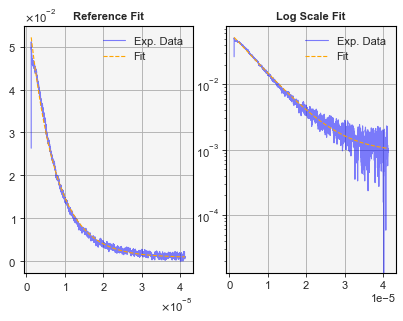

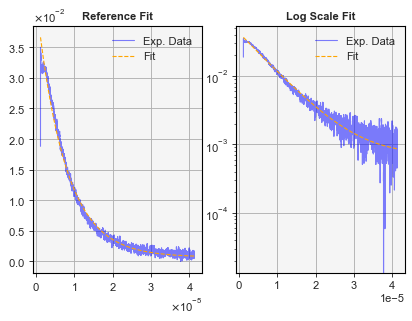

In [22]:
zipped_sgl_data = zip(time_cut_data_sets, trans_avg_cor, list_of_maxs, list_of_mins)
fit_sgl_set = [[ff.fit_exp_decay(time, trans, params=(0.3*max_val, guess_T1, min_val)) for time, trans, max_val, min_val in zip(timme_set, trans_set, max_set, min_set)] for timme_set, trans_set, max_set, min_set in zipped_sgl_data]

# loop over references - fit and plot data of one set per folder
for idx, fitted_set in enumerate(fit_sgl_set):

    fig, ax = mp.subplots(nrows=1, ncols=2)
    
    ax[0].set_title('Reference Fit')
    ax[0].plot(time_cut_data_sets[idx][0], trans_avg_cor[idx][0], color='blue', alpha=0.5, label='Exp. Data')
    ax[0].plot(time_cut_data_sets[idx][0], ff.exp_decay(np.array(time_cut_data_sets[idx][0]), *fitted_set[idx][0]), color='orange', linestyle='--', alpha=1, label='Fit')
    ax[0].ticklabel_format(axis='both', style='sci', scilimits=(0,0), useMathText = True)
    ax[0].legend()

    ax[1].set_title('Log Scale Fit')
    ax[1].plot(time_cut_data_sets[idx][0], trans_avg_cor[idx][0], color='blue', alpha=0.5, label='Exp. Data')
    ax[1].plot(time_cut_data_sets[idx][0], ff.exp_decay(np.array(time_cut_data_sets[idx][0]), *fitted_set[idx][0]), color='orange', linestyle='--', alpha=1, label='Fit')
    ax[1].set_yscale('log')
    ax[1].legend()

    # print out fitted values
    print('Fit Params data[{0}]:'.format(idx))
    print("I0 : {0:2.2f} mV, T1 : {1:2.2f} us, Y0 : {2:2.2f} mV".format(*fitted_set[idx][0]*1E6))
    print('Fit Error data[{0}]:'.format(idx))
    print("dI0 : {0:2.2f} mV, dT1 : {1:2.3f} us, dY0 : {2:2.2f} mV \n".format(*fitted_set[idx][-1]*1E6))

ref_fall_times = [[T1[1][0] for T1 in reference_fitted] for reference_fitted in reference_fit_sets]

In [23]:
from scipy.integrate import simpson

for time, data in zip(time_cut_lists, trans_cut_lists):
    area = simpson(data, time)
    mp.plot(area, 'x')


NameError: name 'time_cut_lists' is not defined


##### Fit To Corrected Data

        Fit to double exponential decay and return array of fit params and errors
      

In [ ]:
# zip data together for list comprehension
zipped_data = zip(time_cut_lists, trans_corrected, list_of_maxs, ref_max_list, list_of_mins, ref_fall_times)
fit_corrected = [ff.fit_dbl_exp_decay(time, trans, params=(0.3*max_val, ref_max, guess_T1, min_val, fall_time)) for time, trans, max_val, ref_max, min_val, fall_time in zipped_data]
# loop over corrected transmitted data - fit and plot data
for idx, time in enumerate(time_cut_lists):
    print(idx)

    fig, ax = mp.subplots(nrows=1, ncols=2)
    
    ax[0].set_title('Fluorescence Fit')
    ax[0].plot(time, trans_corrected[idx], color='blue', alpha=0.5, label='Exp. Data')
    ax[0].plot(time, ff.dbl_exp_decay(np.array(time), *fit_corrected[idx][0]), color='orange', linestyle='--', alpha=1, label='Fit')
    ax[0].ticklabel_format(axis='both', style='sci', scilimits=(0,0), useMathText = True)
    ax[0].legend()
    
    ax[1].set_title('Log Scale Fit')
    ax[1].plot(time, trans_corrected[idx], color='blue', alpha=0.5, label='Exp. Data')
    ax[1].plot(time, ff.dbl_exp_decay(np.array(time), *fit_corrected[idx][0]), color='orange', linestyle='--', alpha=1, label='Fit')
    ax[1].set_yscale('log')
    ax[1].legend()
    print('Fit Params data[{0}]:'.format(idx))
    print("I01 : {0:2.2f} mV, I02 : {1:2.2f} mV, T11 : {2:2.2f} us, T12 : {3:2.2f} us, Y0 : {4:2.2f} mV".format(*fit_corrected[idx][0]*1E6))
    print('Fit Error data[{0}]:'.format(idx))
    print("dI01 : {0:2.2f} mV, dI02 : {1:2.2f} mV, dT11 : {2:2.2f} us, dT12 : {3:2.2f} us, dY0 : {4:2.2f} mV \n".format(*fit_corrected[idx][1]*1E6))

In [ ]:
fit_calc = []